In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import re
from datetime import datetime as dt
import time
import csv
import requests
import urllib.parse
from os.path import exists
import geopandas as gpd

import json

In [3]:
rawGames = pd.read_csv('SteamAppsInfo.csv', encoding = "ISO-8859-1")

In [4]:
rawGames

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
0,1688200,War Of Gold,"Tero Lunkka,Valkeala Software","Aug 22, 2021",0.59,15.0,66%,"['Action', 'Casual', 'Indie']","['Casual', 'Action', '3D Fighter', 'Shooter', ...",All Games,False,You super hero soldier need save robber gold b...,False
1,1688210,Utopia,Iconic Ideaz,"Jan 7, 2022",NaN,NaN,NaN,"['Action', 'Adventure', 'Massively Multiplayer...","['Early Access', 'RPG', 'Survival', 'Colorful'...",All Games,False,UTOPIA is an open world survival game set in a...,False
2,1688220,Fire & Reign,Siphon Shock,Jun 2022,NaN,NaN,NaN,"['Action', 'Indie']","['Bullet Hell', 'Action', ""Shoot 'Em Up"", 'Sho...",All Games,False,Upgrade your warriors and shoot through waves ...,False
3,1688240,Escape from the Office,"ParachuteGames, ImperiumGame","Jul 26, 2021",2.99,12.0,91%,"['Action', 'Indie']","['Action', 'Precision Platformer', 'Perma Deat...",All Games,False,Escape from the Office is a 2D side-scrolling ...,False
4,1688250,PRINCESS IN AIRINESS,Broken Desk,"Jul 26, 2021",3.99,2.0,NaN,"['Action', 'Indie']","['Action', 'Point & Click', '2D Platformer', '...",All Games,False,"To pray for peace, the princess once again fli...",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
113005,1972180,Dub Club,Cyberfunk Studios LLC,"May 20, 2022",0.00,NaN,NaN,"['Casual', 'Free to Play']","['Casual', 'Rhythm', 'Exploration', 'Third Per...",All Games,False,A third person multiplayer virtual music venue...,False
113006,1595760,ScreenSpace,Wave Project,"Apr 23, 2021",1.99,1.0,NaN,"['Casual', 'Indie']","['Casual', 'Clicker', 'Arcade', 'Point & Click...",All Games,False,Test your focus and reflexes in this simplisti...,False
113007,1996680,Fowl Scourge,Void Cup Games,When its done,NaN,NaN,NaN,"['Action', 'Indie', 'RPG']",[],All Games,False,In this Dark Fantasy Action-RPG you are part o...,False
113008,1972250,Project: Maidenless,Grossly Incandescent Games,TBA,NaN,NaN,NaN,"['Action', 'Adventure', 'Indie', 'Massively Mu...","['Early Access', 'Action', 'Adventure', 'RPG',...",All Games,False,Scavenge for loot in an unforgiving world fill...,False


In [5]:
len(rawGames['appId'].to_list())

113010

In [6]:
# with open('appIdList.txt', 'w') as f:
#     f.write(rawGames['appId'].to_list())

In [7]:
#Now to try and get the dates.
#
#Note that this script eliminates dates which don't fit certain date formats.
#
#For example, it converts "Coming Soon" to NaN.
def datesCleaned(dataframe):
    
    datesCleaned = [];
    
    #Convert to dt format
    for i in dataframe['releaseDate']:
        try:
            datesCleaned.append(dt.strptime(i, '%b %d, %Y'))
        except:
            try:
                datesCleaned.append(dt.strptime(i, '%b, %Y'))
                
            except:
                try: datesCleaned.append(dt.strptime(i, '%b %Y'))
                    
                except:
                    datesCleaned.append(np.nan)
            
    datesCleanedSeries = pd.Series(datesCleaned)
    
    datesCleanedSeries.index = dataframe.index
    
    return datesCleanedSeries

datesCleaned = datesCleaned(rawGames)

#Replece release dates with cleaned dates
rawGames['releaseDate'] = datesCleaned
        
# #Add cleaned release dates to dataframes
# ncrpgs_df['releaseDate'] = rpgDatesCleaned[ncrpgs_df.index]
# crpgs_df['releaseDate'] = rpgDatesCleaned[crpgs_df.index]

In [8]:
#Clean all the game tags
def tagsCleaned(games):
    
    tagsCleaned = []
    
    for k in games.index:
        
        #Get rid of \' \s \em etc.
        tagsRemovedSlashes = re.findall(r"'(.*?)'[,\]]",games.tagsList[k]\
                                        .replace("\'s","s").replace("\'em","em")\
                                        .replace("\'Em","Em").replace("\'","''"))
        
        tagsCleaned.append([tagsRemovedSlashes[j].replace("'","") for j in range(len(tagsRemovedSlashes))])
        
    tagsCleanedSeries = pd.Series(tagsCleaned)
    
    tagsCleanedSeries.index = games.index
        
    return tagsCleanedSeries

rawGames['tagsList'] = tagsCleaned(rawGames)

print(rawGames['tagsList'][0])

['Casual', 'Action', '3D Fighter', 'Shooter', 'Runner', 'Real Time Tactics', 'Hero Shooter', '3D', 'Military', 'Stealth', 'Flight', 'Survival', 'Story Rich', 'Combat', 'Singleplayer', 'Third-Person Shooter', 'Vehicular Combat', 'Indie', 'First-Person', 'Character Customization']


In [9]:
#Find all non-DLC RPGs and CRPGs
rpgs = rawGames[[('RPG' in rawGames.tagsList[i]) or ('CRPG' in rawGames.tagsList[i])
                 for i in range(len(rawGames))]][rawGames['dlcBool'] == False]

C:\Users\isam1\AppData\Local\Temp\ipykernel_7288\183280176.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rpgs = rawGames[[('RPG' in rawGames.tagsList[i]) or ('CRPG' in rawGames.tagsList[i])


In [10]:
def tagBool(games,tagNames):
    
    #Check for a tag name in every game in dataframe
    tagBoolSeries = pd.Series([any([tagName in games['tagsList'][j] for tagName in tagNames]) for j in games.index])
    
    tagBoolSeries.index = games.index
    return tagBoolSeries

#Get list of Booleans corresponding to whether the game is a CRPG
crpgBool = tagBool(rpgs, ['CRPG'])

In [11]:
#All CRPGs
crpgs_df = rpgs.copy()[crpgBool.tolist()]

#All non-CRPG RPGs (nCRPGs)
ncrpgs_df = rpgs.copy()[np.logical_not(crpgBool.tolist())]

In [12]:
any([True,False])

True

In [13]:
ncrpgs_df.head()

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
1,1688210,Utopia,Iconic Ideaz,2022-01-07,NaN,NaN,NaN,"['Action', 'Adventure', 'Massively Multiplayer...","[Early Access, RPG, Survival, Colorful, Base B...",All Games,False,UTOPIA is an open world survival game set in a...,False
8,1688320,OneBit Adventure,"Galactic Slice, LLC",2022-08-05,0.00,NaN,NaN,"['Adventure', 'Casual', 'Free to Play', 'Indie...","[Roguelite, Roguelike, Class-Based, Dungeon Cr...",All Games,False,OneBit Adventure is a casual turn-based roguel...,False
26,1688600,Emperial Knights,Yacine Kalache,2022-04-20,9.99,NaN,NaN,"['Action', 'RPG', 'Early Access']","[Action, RPG, Action RPG, Hack and Slash, 3D, ...",All Games,False,You incarnate as a powerful knight to help the...,False
27,1688630,Emperial Knights,Yacine Kalache,2022-04-20,9.99,NaN,NaN,"['Action', 'RPG', 'Early Access']","[Action, RPG, Action RPG, Hack and Slash, 3D, ...",All Games,False,You incarnate as a powerful knight to help the...,False
28,1688640,Cleanup on Isle Goblin,Kilowatt Games,NaT,NaN,NaN,NaN,"['Adventure', 'Indie', 'RPG', 'Simulation']","[Life Sim, RPG, Pixel Graphics, Adventure, Cra...",All Games,False,Isle Goblin has been invaded by destructive hu...,False


In [14]:
crpgs_df.head()

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
218,1686130,Deep Despair 2,BekkerDev Studio,2021-10-08,6.99,67.0,88%,"['Adventure', 'Indie', 'RPG', 'Simulation']","[Sandbox, Crafting, Adventure, Survival, Simul...",All Games,False,Deep Despair 2 is an open world survival adven...,False
458,1684240,Metal Faith,Youth Game,2021-08-02,9.99,NaN,NaN,"['Adventure', 'Indie', 'RPG']","[Adventure, RPG, Action-Adventure, Shooter, Pu...",All Games,False,A 3D adventure puzzle game,False
459,1684250,The Evil Farming Game: Replanted,Jeremy Does Stupid Stuff,NaT,0.00,NaN,NaN,"['Adventure', 'Free to Play', 'Indie', 'RPG']","[RPG, Psychological Horror, Horror, Multiple E...",All Games,False,"What will you do when you, an ordinary farmer,...",False
464,1684310,The Evil Farming Game: Replanted,Jeremy Does Stupid Stuff,NaT,0.00,NaN,NaN,"['Adventure', 'Free to Play', 'Indie', 'RPG']","[RPG, Psychological Horror, Horror, Multiple E...",All Games,False,"What will you do when you, an ordinary farmer,...",False
479,1683870,Crystalreach Islands,Majao Games,NaT,NaN,NaN,NaN,['RPG'],"[RPG, Fantasy, Action RPG, Open World, Sandbox...",All Games,False,Crystalreach Islands is an open-world action R...,False


In [15]:
rpgs.tagsList.replace("\'s","s").replace("\'em","em").replace("\'Em","Em").replace("\'","''")

1         [Early Access, RPG, Survival, Colorful, Base B...
8         [Roguelite, Roguelike, Class-Based, Dungeon Cr...
26        [Action, RPG, Action RPG, Hack and Slash, 3D, ...
27        [Action, RPG, Action RPG, Hack and Slash, 3D, ...
28        [Life Sim, RPG, Pixel Graphics, Adventure, Cra...
                                ...                        
112994    [Casual, Adventure, RPG, JRPG, Turn-Based Tact...
112995    [RPG, Action RPG, 2D Platformer, Pixel Graphic...
113003    [Strategy, Grand Strategy, Turn-Based Strategy...
113004    [Action, RPG, 2D Fighter, 3D Fighter, JRPG, 3D...
113008    [Early Access, Action, Adventure, RPG, Action ...
Name: tagsList, Length: 15689, dtype: object

In [16]:
rpgDates = datesCleaned[rpgs.index]

In [17]:
#Count number of games over the years
def gameGrowth(games,start_date):
    end_date = dt.now().year

    dates = range(start_date,end_date+1)

    gamesCount=[]
    for date in dates:
        #How many games were released before "date"?
        gamesCount.append(len(games[[games['releaseDate'][i].year < date for i in games.index]].index))
        
    return gamesCount

In [18]:
array = [['a','b'], ['a', 'b','c'], ['a']]
result = {x for l in array for x in l}
print(result)

{'a', 'b', 'c'}


In [19]:
#Get game developer location data
gameDevLocations = pd.read_csv('GameDevLocations.csv',skip_blank_lines=True).dropna()

In [20]:
gameDevLocations.head()

,Unnamed: 0,company,city,state/province,country,latitude,longitude,alteredTextBool
0,1,0verflow,Tokyo,Tokyo,Japan,35.681091,139.767186,False
1,3,1 Simple Game,Zapopan,Jalisco,Mexico,20.721120,-103.391367,False
2,5,100 Stones Interactive,Brisbane,Queensland,Australia,-27.468968,153.023499,False
3,7,1047 Games,Zephyr Cove,Nevada,United States,39.006010,-119.947239,False
4,9,10tons,Tampere,Tavastia,Finland,60.945062,24.508888,False


In [21]:
#Add developer location to rawGames
gameDevCityList = [];
gameDevStateProvinceList = [];
gameDevCountryList = [];
for i in range(len(rawGames)):
    if rawGames.loc[i].developerName in gameDevLocations.company.tolist():
        
        gameDev = gameDevLocations[gameDevLocations.company == rawGames.loc[i].developerName]
        
        gameDevCityList.append([gameDev.loc[j][1] for j in gameDev.index])
        gameDevStateProvinceList.append([gameDev.loc[j][2] for j in gameDev.index])
        gameDevCountryList.append([gameDev.loc[j][3] for j in gameDev.index])
        
    else:
        gameDevCityList.append([np.nan])
        gameDevStateProvinceList.append([np.nan])
        gameDevCountryList.append([np.nan])

In [22]:
gameDevCountryList.count([np.nan])/len(gameDevCountryList)

0.9249358463852756

In [23]:
len(rawGames.developerName.unique())

43280

In [24]:
address = 'Tokyo, Tokyo, Japan'
url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'

response = requests.get(url).json()
print(response[0]["lat"])
print(response[0]["lon"])


35.6810912
139.7671861


In [25]:
print('Tokyo'+', '+'Tokyo'+', '+'Japan')

Tokyo, Tokyo, Japan


In [26]:
gameDevLocations.index.size

4054

In [27]:
#Add coordinates to gameDevLocations

if exists('gameDevLocations.csv'):
    gameDevLocations = pd.read_csv('gameDevLocations.csv').set_index('Unnamed: 0')
    gameDevLocations.index.name = None
else:
    latitude = [];
    longitude = [];
    numLoops = 0

    startTime = time.time()

    for company in gameDevLocations.index:
        #Get country name
        try:
            country = gameDevLocations['country'][company]
        except KeyError:
            country = ''

        #Get state/province name
        try:
            stateProvince = gameDevLocations['state/province'][company]
        except KeyError:
            stateProvince = ''

        #Get city name
        try:
            city = gameDevLocations['city'][company]
        except KeyError:
            city = ''

        #Search address and attempt to find latitude and longitude
        address = city+', '+stateProvince+', '+country
        url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
        response = requests.get(url).json()

        try:
            latitude.append(response[0]["lat"])
            longitude.append(response[0]["lon"])
        except IndexError:
            print('Failed to retrieve coordinates for {} at address {}'.format(gameDevLocations['company'][company],address))
            try:
                address = city+', '+country
                url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
                response = requests.get(url).json()
                latitude.append(response[0]["lat"])
                longitude.append(response[0]["lon"])

            except:
                print('Failed AGAIN to retrieve coordinates for {} at address {}'.format(gameDevLocations['company'][company],address))
                latitude.append(np.nan)
                longitude.append(np.nan)

        time.sleep(0.3) #Delay scraping a little bit to be nice

        numLoops += 1
        if numLoops%100 == 0:
            print('Iteration number {} complete. Runtime: {}'.format(numLoops, time.time() - startTime))

    gameDevLocations.insert(4, 'latitude', latitude)
    gameDevLocations.insert(5, 'longitude', longitude)

In [74]:
rawGames['developerName'].to_numpy()

array(['Tero Lunkka,Valkeala Software', 'Iconic Ideaz', 'Siphon Shock',
       ..., 'Void Cup Games', 'Grossly Incandescent Games', 'AOne Games'],
      dtype=object)

In [90]:
for devName in rawGames['developerName'].to_numpy():
    if int(devName.find('Zynga')) != -1:
        print(rawGames.loc(rawGames['developerName'].iloc(devName)))

AttributeError: 'float' object has no attribute 'find'

In [110]:
gameDevLocations.head()

,company,city,state/province,country,latitude,longitude,alteredTextBool
1,0verflow,Tokyo,Tokyo,Japan,35.681091,139.767186,False
3,1 Simple Game,Zapopan,Jalisco,Mexico,20.721120,-103.391367,False
5,100 Stones Interactive,Brisbane,Queensland,Australia,-27.468968,153.023499,False
7,1047 Games,Zephyr Cove,Nevada,United States,39.006010,-119.947239,False
9,10tons,Tampere,Tavastia,Finland,60.945062,24.508888,False


In [124]:
rawGames.dropna(subset='developerName')[[('Bethesda' in devName) for devName in rawGames['developerName'].dropna()]]

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
7271,1343770,Fallout 76: Appalachia Starter Bundle,Bethesda Game Studios,2020-07-09,7.99,130.0,80%,['RPG'],"[RPG, Gore, Violent, Capitalism]",All Games,True,Purchase 800 Atoms (+300 bonus) and get Piper'...,False
24116,1224350,Fallout 76 Tricentennial Pack,Bethesda Game Studios,2020-04-14,NaN,10.0,100%,['RPG'],"[RPG, Violent, Gore]",All Games,True,Emerge fully prepared and patriotically styled...,False
25627,1202520,Fallout 1st,Bethesda Game Studios,2020-04-14,12.99,1149.0,69%,['RPG'],"[Capitalism, Dark Comedy, Comedy, Dark Humor, ...",All Games,True,Fallout 1st is a premium membership that enhan...,False
47899,1812420,An Elder Scrolls Legend: Battlespire,Bethesda Softworks,2022-04-26,5.99,15.0,93%,"['Action', 'RPG']","[RPG, Action, Action RPG, Fantasy, Singleplaye...",All Games,False,TRAPPED IN THE REALM OF DARKNESS,False
51285,1905073,Fallout 76 - Generals Persona Bundle,Bethesda Game Studios,2022-05-12,9.99,8.0,NaN,['RPG'],"[RPG, Gore, Violent]",All Games,True,Buy the 1000 Atoms (+500 bonus) and get the Re...,False
67308,900883,The Elder Scrolls IV: Oblivion® Game of the Ye...,Bethesda Game Studios®,2009-06-16,19.99,28767.0,97%,['Add to Account'],"[RPG, Open World, Fantasy, Singleplayer, Modda...",All Games,False,The Elder Scrolls IV: Oblivion® Game of the Ye...,False
78568,490650,Fallout 4 Nuka-World,Bethesda Game Studios,2016-08-29,9.99,2435.0,63%,['RPG'],"[RPG, Open World, Post-apocalyptic, Singleplay...",All Games,True,"Take a trip to Nuka-World, a vast amusement pa...",False
78618,489830,The Elder Scrolls V: Skyrim Special Edition,Bethesda Game Studios,2016-10-27,39.99,101248.0,94%,['RPG'],"[Open World, RPG, Adventure, Singleplayer, Fan...",All Games,False,Winner of more than 200 Game of the Year Award...,False
79004,480630,Fallout 4 - Contraptions Workshop,Bethesda Game Studios,2016-06-20,4.99,1250.0,38%,['RPG'],"[RPG, Sandbox, Post-apocalyptic, Open World, C...",All Games,True,Machines that sort! Machines that build! Machi...,False
79005,480631,Fallout 4 Vault-Tec Workshop,Bethesda Game Studios,2016-07-25,4.99,1785.0,39%,['RPG'],"[RPG, Base Building, Singleplayer, Post-apocal...",All Games,True,Build a brighter future underground with the a...,False


In [109]:
print(list(rawGames.developerName.unique()))

['Tero Lunkka,Valkeala Software', 'Iconic Ideaz', 'Siphon Shock', 'ParachuteGames, ImperiumGame', 'Broken Desk', 'NLB project', 'Sprovieri Games', 'Genesis Arthangel', 'Galactic Slice, LLC', 'Vidas Salavejus', 'Appstronaut Studios', 'Guillaume Lamontagne', 'Christian tavares da silva', 'TearStorm Entertainment', 'Team Haruko Please', 'Narog Games', 'SmartOliveGames Ltd', 'Crooked Road', 'Tlön Industries', 'PITR', 'Cast n Play', 'Exbyte Studios', 'L.S. Frei', 'Graviteam', 'npckc', 'ImageTech LLC', 'Yacine Kalache', 'Kilowatt Games', 'whaleo', 'TigerQiuQiu', 'GIRLSOUL', 'The Pixel Hunt', 'Overseer Games', 'KseLeroN', 'CUTE ANIME GIRLS', nan, 'Boris Cerdan', '751 Games', 'Flashback Games', 'The Artistocrats', 'Lior Hanina', 'gypynkt', '62bits', 'Triority Interactive Novels', 'Acid Mines Software UG', 'Ferulox Studios', 'Bird Bath Games', 'Starlit Castle', 'IRON GAMES', 'Pyxeralia', 'Terahard Ltd', 'YoYo Games Ltd.', 'Bethuel K. Okelo', 'Blue Monocle Software', 'Krysta Games', 'Nodtech Cre

In [122]:
steamDevs = list(rawGames.developerName.dropna().unique())
mapDevs = list(gameDevLocations.dropna().company)

matchCounts = 0

for mapDevName in mapDevs:
    for steamDevName in steamDevs:
        if steamDevName.find(mapDevName) != -1:
            matchCounts += 1
            print('Success! \n steamDevName: {} \n mapDevName: {} \n Matches: {}'.format(steamDevName,mapDevName,matchCounts))
            
            break
                

Success! 
 steamDevName: 1 Simple Game 
 mapDevName: 1 Simple Game 
 Matches: 1
Success! 
 steamDevName: 100 Stones Interactive 
 mapDevName: 100 Stones Interactive 
 Matches: 2
Success! 
 steamDevName: 1047 Games 
 mapDevName: 1047 Games 
 Matches: 3
Success! 
 steamDevName: 10tons Ltd 
 mapDevName: 10tons 
 Matches: 4
Success! 
 steamDevName: 12 East Games 
 mapDevName: 12 East Games 
 Matches: 5
Success! 
 steamDevName: 12 Hit Combo 
 mapDevName: 12 Hit Combo 
 Matches: 6
Success! 
 steamDevName: 13AM Games,WayForward 
 mapDevName: 13AM Games 
 Matches: 7
Success! 
 steamDevName: 2 Ton Studios 
 mapDevName: 2 Ton Studios 
 Matches: 8
Success! 
 steamDevName: 22cans 
 mapDevName: 22cans 
 Matches: 9
Success! 
 steamDevName: 2Dogs Games Ltd. 
 mapDevName: 2Dogs Games 
 Matches: 10
Success! 
 steamDevName: 2Pi Interactive Pvt. Ltd. 
 mapDevName: 2Pi Interactive 
 Matches: 11
Success! 
 steamDevName: 3-Fold Games 
 mapDevName: 3-Fold Games 
 Matches: 12
Success! 
 steamDevName: 3000AD 


Success! 
 steamDevName: Arkadium 
 mapDevName: Arkadium 
 Matches: 103
Success! 
 steamDevName: Arkadium 
 mapDevName: Arkadium 
 Matches: 104
Success! 
 steamDevName: Armature Studio, LLC,Comcept 
 mapDevName: Armature Studio 
 Matches: 105
Success! 
 steamDevName: Virtual Heroes,Army Game Studio 
 mapDevName: Army Game Studio 
 Matches: 106
Success! 
 steamDevName: Arrible 
 mapDevName: Arrible 
 Matches: 107
Success! 
 steamDevName: Arrible 
 mapDevName: Arrible 
 Matches: 108
Success! 
 steamDevName: Arsanesia 
 mapDevName: Arsanesia 
 Matches: 109
Success! 
 steamDevName: Art Co. Ltd,PQube 
 mapDevName: Art Co 
 Matches: 110
Success! 
 steamDevName: Artdink 
 mapDevName: Artdink 
 Matches: 111
Success! 
 steamDevName: Artefacts Studio 
 mapDevName: Artefacts Studio 
 Matches: 112
Success! 
 steamDevName: Artematica Entertainment 
 mapDevName: Artematica Entertainment 
 Matches: 113
Success! 
 steamDevName: Uncle Artie 
 mapDevName: Artie 
 Matches: 114
Success! 
 steamDevName: Ar

Success! 
 steamDevName: Blazing Griffin 
 mapDevName: Blazing Griffin 
 Matches: 207
Success! 
 steamDevName: Blendo Games 
 mapDevName: Blendo Games 
 Matches: 208
Success! 
 steamDevName: Blind Sky Studios 
 mapDevName: Blind Sky Studios 
 Matches: 209
Success! 
 steamDevName: Insomniac Games,Blind Squirrel Games 
 mapDevName: Blind Squirrel Games 
 Matches: 210
Success! 
 steamDevName: Michel Barengo,Blindflug Studios AG 
 mapDevName: Blindflug Studios 
 Matches: 211
Success! 
 steamDevName: Bloober Team SA 
 mapDevName: Bloober Team 
 Matches: 212
Success! 
 steamDevName: Bloom Digital Media 
 mapDevName: Bloom Digital Media 
 Matches: 213
Success! 
 steamDevName: Blot Interactive 
 mapDevName: Blot Interactive 
 Matches: 214
Success! 
 steamDevName: Blowfish Studios 
 mapDevName: Blowfish Studios 
 Matches: 215
Success! 
 steamDevName: Blue Bomber Games 
 mapDevName: Blue Bomber Games 
 Matches: 216
Success! 
 steamDevName: Blue Bottle Games 
 mapDevName: Blue Bottle Games 
 Matc

 Matches: 309
Success! 
 steamDevName: Chump Squad 
 mapDevName: Chump Squad 
 Matches: 310
Success! 
 steamDevName: Chunkybox Games 
 mapDevName: Chunkybox Games 
 Matches: 311
Success! 
 steamDevName: Cipher Prime Studios 
 mapDevName: Cipher Prime Studios 
 Matches: 312
Success! 
 steamDevName: Circle 5 Studios 
 mapDevName: Circle 5 Studios 
 Matches: 313
Success! 
 steamDevName: City State Entertainment 
 mapDevName: City State Entertainment 
 Matches: 314
Success! 
 steamDevName: City State Entertainment 
 mapDevName: City State Entertainment 
 Matches: 315
Success! 
 steamDevName: Claudiu Kiss,The Irregular Corporation 
 mapDevName: Claudiu Kiss 
 Matches: 316
Success! 
 steamDevName: Cleaversoft 
 mapDevName: Cleaversoft 
 Matches: 317
Success! 
 steamDevName: Clever Beans 
 mapDevName: Clever Beans 
 Matches: 318
Success! 
 steamDevName: Clifftop Games 
 mapDevName: Clifftop Games 
 Matches: 319
Success! 
 steamDevName: Neko Climax Studios 
 mapDevName: Climax Studios 
 Matche

 Matches: 416
Success! 
 steamDevName: Dark-1 
 mapDevName: Dark-1 
 Matches: 417
Success! 
 steamDevName: Darkflow Software 
 mapDevName: Darkflow Software 
 Matches: 418
Success! 
 steamDevName: Darkling Room 
 mapDevName: Darkling Room 
 Matches: 419
Success! 
 steamDevName: Camouflaj,Darkwind Media 
 mapDevName: Darkwind Media 
 Matches: 420
Success! 
 steamDevName: Data Realms 
 mapDevName: Data Realms 
 Matches: 421
Success! 
 steamDevName: Dave Sapien 
 mapDevName: Dave Sapien 
 Matches: 422
Success! 
 steamDevName: David Czarnowski 
 mapDevName: David Czarnowski 
 Matches: 423
Success! 
 steamDevName: Daylight Studios 
 mapDevName: Daylight Studios 
 Matches: 424
Success! 
 steamDevName: Days of Wonder 
 mapDevName: Days of Wonder 
 Matches: 425
Success! 
 steamDevName: Days of Wonder 
 mapDevName: Days of Wonder 
 Matches: 426
Success! 
 steamDevName: Dead Mage 
 mapDevName: Dead Mage 
 Matches: 427
Success! 
 steamDevName: Dead Unicorn 
 mapDevName: Dead Unicorn 
 Matches: 42

Success! 
 steamDevName: Embark Studios 
 mapDevName: Embark Studios 
 Matches: 522
Success! 
 steamDevName: Empty Clip Studios 
 mapDevName: Empty Clip Studios 
 Matches: 523
Success! 
 steamDevName: Encircle Games 
 mapDevName: Encircle Games 
 Matches: 524
Success! 
 steamDevName: Endgame Studios 
 mapDevName: Endgame Studios 
 Matches: 525
Success! 
 steamDevName: Nihon Falcom,Engine Software BV,PH3 GmbH 
 mapDevName: Engine Software 
 Matches: 526
Success! 
 steamDevName: Enigami 
 mapDevName: Enigami 
 Matches: 527
Success! 
 steamDevName: Enigma Studios LLC 
 mapDevName: Enigma Studios 
 Matches: 528
Success! 
 steamDevName: Enlight Software Limited, PerspectX 
 mapDevName: Enlight Software 
 Matches: 529
Success! 
 steamDevName: Ennui Studio 
 mapDevName: Ennui Studio 
 Matches: 530
Success! 
 steamDevName: Entrada Interactive LLC 
 mapDevName: Entrada Interactive 
 Matches: 531
Success! 
 steamDevName: Envision Entertainment 
 mapDevName: Envision Entertainment 
 Matches: 532


Success! 
 steamDevName: Fast Forward Games 
 mapDevName: Forward Games 
 Matches: 627
Success! 
 steamDevName: Sketchbook Games,Fourth State 
 mapDevName: Fourth State 
 Matches: 628
Success! 
 steamDevName: Foxy Voxel 
 mapDevName: Foxy Voxel 
 Matches: 629
Success! 
 steamDevName: Fractal Box,Moving Player 
 mapDevName: Fractal Box 
 Matches: 630
Success! 
 steamDevName: Fractal Phase 
 mapDevName: Fractal Phase 
 Matches: 631
Success! 
 steamDevName: Frame Interactive 
 mapDevName: Frame Interactive 
 Matches: 632
Success! 
 steamDevName: Freaky Creations 
 mapDevName: Freaky Creations 
 Matches: 633
Success! 
 steamDevName: frecle 
 mapDevName: frecle 
 Matches: 634
Success! 
 steamDevName: Free Lives 
 mapDevName: Free Lives 
 Matches: 635
Success! 
 steamDevName: Free Range Games 
 mapDevName: Free Range Games 
 Matches: 636
Success! 
 steamDevName: Freehold Games 
 mapDevName: Freehold Games 
 Matches: 637
Success! 
 steamDevName: Freemergency 
 mapDevName: Freemergency 
 Match

 Matches: 735
Success! 
 steamDevName: Pocket Games,Fluid Games,GodSpeed Games 
 mapDevName: GodSpeed Games 
 Matches: 736
Success! 
 steamDevName: Goldborough Studio 
 mapDevName: Goldborough Studio 
 Matches: 737
Success! 
 steamDevName: Golden Ruby Games 
 mapDevName: Golden Ruby Games 
 Matches: 738
Success! 
 steamDevName: Goldhawk Interactive 
 mapDevName: Goldhawk Interactive 
 Matches: 739
Success! 
 steamDevName: Golem House 
 mapDevName: Golem House 
 Matches: 740
Success! 
 steamDevName: GolemLabs 
 mapDevName: GolemLabs 
 Matches: 741
Success! 
 steamDevName: Goloso Games 
 mapDevName: Goloso Games 
 Matches: 742
Success! 
 steamDevName: Goon Studios 
 mapDevName: Goon Studios 
 Matches: 743
Success! 
 steamDevName: Gorilla Tactics 
 mapDevName: Gorilla Tactics 
 Matches: 744
Success! 
 steamDevName: Gossamer Games 
 mapDevName: Gossamer Games 
 Matches: 745
Success! 
 steamDevName: Grace Bruxner,Thomas Bowker 
 mapDevName: Grace Bruxner 
 Matches: 746
Success! 
 steamDevNa

 Matches: 843
Success! 
 steamDevName: Hopoo Games 
 mapDevName: Hopoo Games 
 Matches: 844
Success! 
 steamDevName: Hothead Games 
 mapDevName: Hothead Games 
 Matches: 845
Success! 
 steamDevName: House House 
 mapDevName: House House 
 Matches: 846
Success! 
 steamDevName: House of How 
 mapDevName: House of How 
 Matches: 847
Success! 
 steamDevName: House Pixel Games 
 mapDevName: House Pixel Games 
 Matches: 848
Success! 
 steamDevName: Household Games Inc. 
 mapDevName: Household Games 
 Matches: 849
Success! 
 steamDevName: HumaNature Studios 
 mapDevName: HumaNature Studios 
 Matches: 850
Success! 
 steamDevName: Humble Grove,Hana Lee,Cel Davison,Adrienne Lombardo,Eli Rainsberry 
 mapDevName: Humble Grove 
 Matches: 851
Success! 
 steamDevName: Humble Grove,Hana Lee,Cel Davison,Adrienne Lombardo,Eli Rainsberry 
 mapDevName: Humble Grove 
 Matches: 852
Success! 
 steamDevName: Hungry Couch Games 
 mapDevName: Hungry Couch Games 
 Matches: 853
Success! 
 steamDevName: Hunted Cow

Success! 
 steamDevName: JOYCITY 
 mapDevName: JOYCITY 
 Matches: 936
Success! 
 steamDevName: JoyMasher 
 mapDevName: JoyMasher 
 Matches: 937
Success! 
 steamDevName: Juggernaut Games 
 mapDevName: Juggernaut Games 
 Matches: 938
Success! 
 steamDevName: Klabater,Juggler Games 
 mapDevName: Juggler Games 
 Matches: 939
Success! 
 steamDevName: Juicy Beast 
 mapDevName: Juicy Beast 
 Matches: 940
Success! 
 steamDevName: Jujubee S.A. 
 mapDevName: Jujubee 
 Matches: 941
Success! 
 steamDevName: Jumpdrive Studios 
 mapDevName: Jumpdrive Studios 
 Matches: 942
Success! 
 steamDevName: Jumpship 
 mapDevName: Jumpship 
 Matches: 943
Success! 
 steamDevName: Juppiomenz 
 mapDevName: Juppiomenz 
 Matches: 944
Success! 
 steamDevName: Maze Theory Ltd,Just Add Water (Developments), Ltd. 
 mapDevName: Just Add Water (Developments) 
 Matches: 945
Success! 
 steamDevName: Just Flight 
 mapDevName: Just Flight 
 Matches: 946
Success! 
 steamDevName: Just Funny Games 
 mapDevName: Just Funny Games

Success! 
 steamDevName: Little Rock Games 
 mapDevName: Little Rock Games 
 Matches: 1044
Success! 
 steamDevName: MAKSIM VOLKAU 
 mapDevName: LKA 
 Matches: 1045
Success! 
 steamDevName: Llamasoft Ltd. 
 mapDevName: Llamasoft 
 Matches: 1046
Success! 
 steamDevName: Lofty Sky Entertainment Inc.,Lofty Sky Games 
 mapDevName: Lofty Sky Entertainment 
 Matches: 1047
Success! 
 steamDevName: Logic Artists 
 mapDevName: Logic Artists 
 Matches: 1048
Success! 
 steamDevName: Long Neck Games 
 mapDevName: Long Neck Games 
 Matches: 1049
Success! 
 steamDevName: Longbow Games 
 mapDevName: Longbow Games 
 Matches: 1050
Success! 
 steamDevName: Love Conquers All Games 
 mapDevName: Love Conquers All Games 
 Matches: 1051
Success! 
 steamDevName: Loveshack Entertainment 
 mapDevName: Loveshack 
 Matches: 1052
Success! 
 steamDevName: Lozange Lab 
 mapDevName: Lozange Lab 
 Matches: 1053
Success! 
 steamDevName: Lucid Dreams Studio 
 mapDevName: Lucid Dreams Studio 
 Matches: 1054
Success! 
 st

Success! 
 steamDevName: Mojo Bones Ltd 
 mapDevName: Mojo Bones 
 Matches: 1157
Success! 
 steamDevName: Molleindustria 
 mapDevName: Molleindustria 
 Matches: 1158
Success! 
 steamDevName: Momentum Digital Media Technologies 
 mapDevName: Momentum Digital Media Technologies 
 Matches: 1159
Success! 
 steamDevName: Mommy's Best Games 
 mapDevName: Mommy's Best Games 
 Matches: 1160
Success! 
 steamDevName: Monochrome, Inc 
 mapDevName: Monochrome 
 Matches: 1161
Success! 
 steamDevName: Monomi Park 
 mapDevName: Monomi Park 
 Matches: 1162
Success! 
 steamDevName: Monothetic LLC 
 mapDevName: Monothetic 
 Matches: 1163
Success! 
 steamDevName: Monstars Inc.,Resonair,Stage Games 
 mapDevName: Monstars 
 Matches: 1164
Success! 
 steamDevName: Monster Couch 
 mapDevName: Monster Couch 
 Matches: 1165
Success! 
 steamDevName: Moon Lagoon 
 mapDevName: Moon Lagoon 
 Matches: 1166
Success! 
 steamDevName: Moon Moose 
 mapDevName: Moon Moose 
 Matches: 1167
Success! 
 steamDevName: Wolfs Moo

 Matches: 1262
Success! 
 steamDevName: Ogre Pixel 
 mapDevName: Ogre Pixel 
 Matches: 1263
Success! 
 steamDevName: blissbox,0edit,OhNoo Studio,Smile 
 mapDevName: OhNoo Studio 
 Matches: 1264
Success! 
 steamDevName: Okomotive 
 mapDevName: Okomotive 
 Matches: 1265
Success! 
 steamDevName: Old Skull Games,GameHouse 
 mapDevName: Old Skull Games 
 Matches: 1266
Success! 
 steamDevName: Oldmoustache Gameworks 
 mapDevName: Oldmoustache Gameworks 
 Matches: 1267
Success! 
 steamDevName: Pie for Breakfast Studios,Omiya Games 
 mapDevName: Omiya Games 
 Matches: 1268
Success! 
 steamDevName: One More Game 
 mapDevName: One More Game 
 Matches: 1269
Success! 
 steamDevName: One More Level,3D Realms,Slipgate Ironworks 
 mapDevName: One More Level 
 Matches: 1270
Success! 
 steamDevName: Onion Games 
 mapDevName: Onion Games 
 Matches: 1271
Success! 
 steamDevName: OnionBlaze 
 mapDevName: OnionBlaze 
 Matches: 1272
Success! 
 steamDevName: Only By Midnight Ltd. 
 mapDevName: Only By Midni

 Matches: 1367
Success! 
 steamDevName: Pipeworks Studios 
 mapDevName: Pipeworks Studios 
 Matches: 1368
Success! 
 steamDevName: Piranaking 
 mapDevName: Piranaking 
 Matches: 1369
Success! 
 steamDevName: Piranha Bytes 
 mapDevName: Piranha Bytes 
 Matches: 1370
Success! 
 steamDevName: Piranha Games Inc. 
 mapDevName: Piranha Games 
 Matches: 1371
Success! 
 steamDevName: Pixadome 
 mapDevName: Pixadome 
 Matches: 1372
Success! 
 steamDevName: The Pixel Hunt 
 mapDevName: Pixel 
 Matches: 1373
Success! 
 steamDevName: Pixel by Pixel Studios Inc. 
 mapDevName: Pixel by Pixel Studios 
 Matches: 1374
Success! 
 steamDevName: EQ-Games , Pixel Dash Studios 
 mapDevName: Pixel Dash Studios 
 Matches: 1375
Success! 
 steamDevName: Pixel Delusion 
 mapDevName: Pixel Delusion 
 Matches: 1376
Success! 
 steamDevName: Pixel Federation 
 mapDevName: Pixel Federation 
 Matches: 1377
Success! 
 steamDevName: Pixel Night 
 mapDevName: Pixel Night 
 Matches: 1378
Success! 
 steamDevName: Pixel Per

 Matches: 1464
Success! 
 steamDevName: Raba Games 
 mapDevName: Raba Games 
 Matches: 1465
Success! 
 steamDevName: RAC7 
 mapDevName: RAC7 
 Matches: 1466
Success! 
 steamDevName: Raconteur Games 
 mapDevName: Raconteur Games 
 Matches: 1467
Success! 
 steamDevName: Dejobaan Games,Radial Games 
 mapDevName: Radial Games 
 Matches: 1468
Success! 
 steamDevName: Radiation Blue 
 mapDevName: Radiation Blue 
 Matches: 1469
Success! 
 steamDevName: Radical Fish Games 
 mapDevName: Radical Fish Games 
 Matches: 1470
Success! 
 steamDevName: RageSquid 
 mapDevName: RageSquid 
 Matches: 1471
Success! 
 steamDevName: Rain Games 
 mapDevName: Rain Games 
 Matches: 1472
Success! 
 steamDevName: Rainbite Ltd 
 mapDevName: Rainbite 
 Matches: 1473
Success! 
 steamDevName: Ranida Games 
 mapDevName: Ranida Games 
 Matches: 1474
Success! 
 steamDevName: Rare Camel Studios 
 mapDevName: Rare 
 Matches: 1475
Success! 
 steamDevName: Rarebyte 
 mapDevName: Rarebyte 
 Matches: 1476
Success! 
 steamDevN

Success! 
 steamDevName: Sabotage Studio 
 mapDevName: Sabotage Studio 
 Matches: 1569
Success! 
 steamDevName: Sad Cat Studios 
 mapDevName: Sad Cat Studios 
 Matches: 1570
Success! 
 steamDevName: Sad Panda Studios 
 mapDevName: Sad Panda Studios 
 Matches: 1571
Success! 
 steamDevName: Sailboat Studios 
 mapDevName: Sailboat Studios 
 Matches: 1572
Success! 
 steamDevName: Sakura River Interactive 
 mapDevName: Sakura River Interactive 
 Matches: 1573
Success! 
 steamDevName: Salix Games Ltd,Tea Clipper Games Ltd 
 mapDevName: Salix Games 
 Matches: 1574
Success! 
 steamDevName: Salty Lemon Entertainment 
 mapDevName: Salty Lemon Entertainment 
 Matches: 1575
Success! 
 steamDevName: Samobee Games 
 mapDevName: Samobee Games 
 Matches: 1576
Success! 
 steamDevName: Samurai Punk 
 mapDevName: Samurai Punk 
 Matches: 1577
Success! 
 steamDevName: Sand Sailor Studio 
 mapDevName: Sand Sailor Studio 
 Matches: 1578
Success! 
 steamDevName: Santa Ragione 
 mapDevName: Santa Ragione 
 Mat

 Matches: 1684
Success! 
 steamDevName: Soma Games 
 mapDevName: Soma Games 
 Matches: 1685
Success! 
 steamDevName: Sombr Studio 
 mapDevName: Sombr Studio 
 Matches: 1686
Success! 
 steamDevName: SoulGame Studio 
 mapDevName: SoulGame Studio 
 Matches: 1687
Success! 
 steamDevName: Sourena Game Studio 
 mapDevName: Sourena Game Studio 
 Matches: 1688
Success! 
 steamDevName: Space Bullet Dynamics Corporation 
 mapDevName: Space Bullet Dynamics Corporation 
 Matches: 1689
Success! 
 steamDevName: Space Lizard Studio 
 mapDevName: Space Lizard Studio 
 Matches: 1690
Success! 
 steamDevName: SpaceFox Studio 
 mapDevName: SpaceFox Studio 
 Matches: 1691
Success! 
 steamDevName: Spaces of Play UG 
 mapDevName: Spaces of Play 
 Matches: 1692
Success! 
 steamDevName: Spacewave Software 
 mapDevName: Spacewave Software 
 Matches: 1693
Success! 
 steamDevName: Sparkypants Studios LLC 
 mapDevName: Sparkypants Studios 
 Matches: 1694
Success! 
 steamDevName: SPARSE//GameDev 
 mapDevName: SPARS

 Matches: 1776
Success! 
 steamDevName: Studio Wildcard,Instinct Games,Efecto Studios,Virtual Basement LLC 
 mapDevName: Studio Wildcard 
 Matches: 1777
Success! 
 steamDevName: Studio Wumpus 
 mapDevName: Studio Wumpus 
 Matches: 1778
Success! 
 steamDevName: Studio Zevere 
 mapDevName: Studio Zevere 
 Matches: 1779
Success! 
 steamDevName: Subset Games 
 mapDevName: Subset Games 
 Matches: 1780
Success! 
 steamDevName: SuckerFree Games 
 mapDevName: SuckerFree Games 
 Matches: 1781
Success! 
 steamDevName: Sudden Event Studios 
 mapDevName: Sudden Event Studios 
 Matches: 1782
Success! 
 steamDevName: Sukeban Games 
 mapDevName: Sukeban Games 
 Matches: 1783
Success! 
 steamDevName: Summerfall Studios 
 mapDevName: Summerfall Studios 
 Matches: 1784
Success! 
 steamDevName: Sumo Digital 
 mapDevName: Sumo Digital 
 Matches: 1785
Success! 
 steamDevName: Sumo Digital 
 mapDevName: Sumo Digital 
 Matches: 1786
Success! 
 steamDevName: Sundae Month 
 mapDevName: Sundae Month 
 Matches: 

 Matches: 1890
Success! 
 steamDevName: Thunder Lotus Games 
 mapDevName: Thunder Lotus Games 
 Matches: 1891
Success! 
 steamDevName: Thunderbox Entertainment 
 mapDevName: Thunderbox Entertainment 
 Matches: 1892
Success! 
 steamDevName: Tidbits Play 
 mapDevName: Tidbits Play 
 Matches: 1893
Success! 
 steamDevName: Tiger Style 
 mapDevName: Tiger Style 
 Matches: 1894
Success! 
 steamDevName: Timbre Interactive 
 mapDevName: Timbre Interactive 
 Matches: 1895
Success! 
 steamDevName: Timecode DS Ltd. 
 mapDevName: Timecode 
 Matches: 1896
Success! 
 steamDevName: Tindalos Interactive 
 mapDevName: Tindalos Interactive 
 Matches: 1897
Success! 
 steamDevName: Tinimations 
 mapDevName: Tinimations 
 Matches: 1898
Success! 
 steamDevName: Tiny Bull Studios 
 mapDevName: Tiny Bull Studios 
 Matches: 1899
Success! 
 steamDevName: Tiny Lions 
 mapDevName: Tiny Lions 
 Matches: 1900
Success! 
 steamDevName: Toadhouse Games 
 mapDevName: Toadhouse Games 
 Matches: 1901
Success! 
 steamDevN

Success! 
 steamDevName: Vanimals 
 mapDevName: Vanimals 
 Matches: 1997
Success! 
 steamDevName: Variable State 
 mapDevName: Variable State 
 Matches: 1998
Success! 
 steamDevName: Vaulted Sky Games 
 mapDevName: Vaulted Sky Games 
 Matches: 1999
Success! 
 steamDevName: Vblank Entertainment, Inc. 
 mapDevName: Vblank Entertainment 
 Matches: 2000
Success! 
 steamDevName: Vector Unit 
 mapDevName: Vector Unit 
 Matches: 2001
Success! 
 steamDevName: Veewo Games 
 mapDevName: Veewo Games 
 Matches: 2002
Success! 
 steamDevName: Velan Studios 
 mapDevName: Velan Studios 
 Matches: 2003
Success! 
 steamDevName: Vertical Reach 
 mapDevName: Vertical 
 Matches: 2004
Success! 
 steamDevName: Vertice Games 
 mapDevName: Vertice Games 
 Matches: 2005
Success! 
 steamDevName: Vertigo Gaming Inc. 
 mapDevName: Vertigo Gaming 
 Matches: 2006
Success! 
 steamDevName: Vile Monarch 
 mapDevName: Vile Monarch 
 Matches: 2007
Success! 
 steamDevName: ViquaSoft 
 mapDevName: ViquaSoft 
 Matches: 2008

In [115]:
stop = False

for x in [1,2,3,4,5]:
    if stop:
        break
    print('x = ',x)
    for y in [3,7,8]:
        print('y =',y)
        if x == y:
            print('Success!',x,y)
            stop = True
            break

x =  1
y = 3
y = 7
y = 8
x =  2
y = 3
y = 7
y = 8
x =  3
y = 3
Success! 3 3


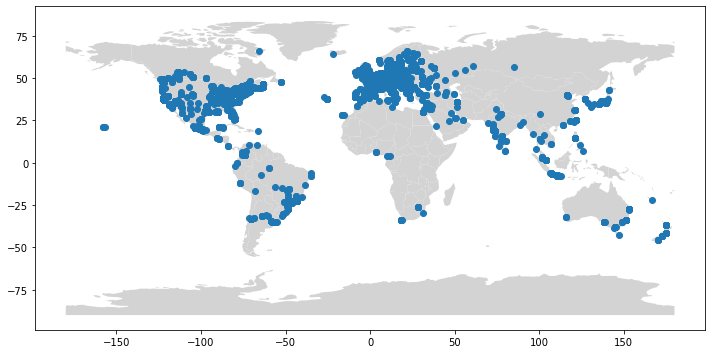

In [35]:
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

# Plotting game dev locations
x = gameDevLocations['longitude']
y = gameDevLocations['latitude']
plt.scatter(x, y)

In [ ]:
#Make geospatial plot of game dev locations

In [115]:
#Find number of games with each tag in every year since oldest game on Steam

from os.path import exists

startDate = min(rawGames['releaseDate']).year
endDate = dt.now().year

#All unique tag names
uniqueTagNames = pd.Series([j for i in range(len(rawGames.tagsList)) for j in rawGames.tagsList[i]]).unique()

startTime = time.time()

if exists('SteamGamesTimeSeries.csv'):
    gamesTimeSeries = pd.read_csv('SteamGamesTimeSeries.csv')
    timeSeriesCSV.close()
    print('SteamGamesTimeSeries already exists.')

else:
    timeSeriesCSV = open('SteamGamesTimeSeries.csv','w+')
    writer = csv.writer(timeSeriesCSV)
    writer.writerow(tuple(['tagName']+[i for i in range(startDate,endDate+1)]))
    
    for tag in uniqueTagNames:
        dates = range(startDate,endDate+1)

        gamesCount=[]
        for date in dates:
            #How many games with this tag were released before "date"?
            
            tagGames = rawGames[tagBool(rawGames,[tag])]

            gamesCount.append(len(tagGames[[tagGames['releaseDate'][i].year < date for i in tagGames.index]].index))
            
        writer.writerow(tuple([tag] + gamesCount))
        
    timeSeriesCSV.close()
    
print(time.time() - startTime)
            
        

    

12764.020555973053


In [15]:
allGamesCount = gameGrowth(rawGames,min(ncrpgs_df['releaseDate']).year)

In [16]:
ncrpgCount = gameGrowth(ncrpgs_df,min(ncrpgs_df['releaseDate']).year)

In [17]:
crpgCount = gameGrowth(crpgs_df,min(ncrpgs_df['releaseDate']).year)

In [61]:
#How much porn is there on Steam?
startTime = time.time()
pornBool = tagBool(rawGames,['Nudity','Hentai','Mature'])
pornGames = rawGames[pornBool]


pornGamesCount = gameGrowth(pornGames,1985)

print(time.time() - startTime)

4.763958215713501


In [19]:
pornGames.head()

,appId,name,developerName,releaseDate,price,numReviews,positiveReviewPercentage,appGenre,tagsList,appType,dlcBool,appDesc,alteredTextBool
7,1688310,Perfect Affection Plan: Cassiopeia,Genesis Arthangel,2021-07-20,14.99,2.0,NaN,['Simulation'],"[Sexual Content, Simulation, Clicker, 2D, Anim...",All Games,False,"Kaede Uzuki, Everyone loves her, but finds lon...",False
57,1688000,My Cute Pagangirl - FREE Girls pack,CUTE ANIME GIRLS,2021-07-22,0.00,5.0,NaN,"['Adventure', 'Casual', 'Indie']","[Adventure, Indie, Casual, Nudity, Sexual Cont...",All Games,True,DLC ! GIRLS MODE .,True
124,1687780,THE ADVENTURES OF LWANDA MAGERE,Bethuel K. Okelo,2021-09-10,4.99,2.0,NaN,"['Action', 'Adventure', 'Indie']","[Adventure, Action, Singleplayer, Action-Adven...",All Games,False,This is an action-adventure game based on the ...,False
159,1687170,Buoy,Dmitry Klimov,NaT,NaN,NaN,NaN,"['Adventure', 'Indie', 'RPG', 'Simulation', 'E...","[Adventure, Survival, Crafting, Building, Mult...",All Games,False,After the cataclysm that occurred on planet Ea...,False
169,1687400,Pixie Farm VR / VR,kan.kikuchi,NaT,NaN,NaN,NaN,['Simulation'],"[Simulation, VR, Anime, Cute, Hentai, Roguelit...",All Games,False,Pixie Farm VR is a pixie raising simulation VR...,False


In [203]:
rawGames[rawGames.name == "Baldur's Gate II: Enhanced Edition"].tagsList.tolist()

[['RPG',
  'Dungeons & Dragons',
  'Fantasy',
  'Story Rich',
  'Tabletop',
  'CRPG',
  'Party-Based RPG',
  'Open World',
  'Adventure',
  'Real-Time with Pause',
  'Character Customization',
  'Multiplayer',
  'Choices Matter',
  'Magic',
  'Online Co-Op',
  'Atmospheric',
  'Action-Adventure',
  'Singleplayer',
  'Isometric',
  'Old School']]

In [37]:
tagTS = pd.read_csv('SteamGamesTimeSeries.csv',index_col=0)

In [53]:
tagTS.head()

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
tagName,,,,,,,,,,,,,,,,,,,,,
Casual,0,0,0,0,0,0,0,0,0,0,...,1136,1501,2360,3791,6403,10180,15357,20301,26642,36105
Action,0,1,1,1,1,1,1,1,1,1,...,2356,3014,4116,6030,9101,13361,18650,24300,30835,40036
3D Fighter,0,0,0,0,0,0,0,0,0,0,...,6,7,11,13,21,34,45,67,182,439
Shooter,0,0,0,0,0,0,0,0,0,0,...,710,803,1002,1246,1577,2038,2568,3129,4339,6129
Runner,0,0,0,0,0,0,0,0,0,0,...,6,11,21,39,75,119,180,240,423,832


In [39]:
#Function to plot number of games with certain tags over time
def tagNumberPlot(tagNameList):
    plt.figure()

    #Define time range: oldest game on steam to current year
    startDate = min(rawGames['releaseDate']).year
    endDate = dt.now().year
    
    dates = range(startDate,endDate+1)
    
    #Plot all tag time series
    for tag in tagNameList:
        plt.plot(dates, tagTS.loc[tag].values, label=tag)
    
    plt.xlabel('Year')
    plt.ylabel('Number games')

    plt.grid()
    plt.legend()
    return

In [43]:
totalGamesCount = gameGrowth(rawGames,min(rawGames['releaseDate']).year)

In [54]:
totalGamesCount

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 6,
 9,
 16,
 22,
 37,
 53,
 77,
 94,
 115,
 154,
 197,
 245,
 292,
 345,
 411,
 475,
 530,
 604,
 666,
 767,
 857,
 981,
 1182,
 1387,
 1687,
 2157,
 2767,
 3597,
 4861,
 6316,
 9074,
 13621,
 21079,
 31249,
 44005,
 57072,
 72244,
 92422]

In [44]:
#Function to plot proportion of games with certain tags over time
def tagProportionPlot(tagNameList):
    plt.figure()

    #Define time range: oldest game on steam to current year
    startDate = min(rawGames['releaseDate']).year
    endDate = dt.now().year
    
    dates = range(startDate,endDate+1)
    
    #Plot all tag time series
    for tag in tagNameList:
        plt.plot(dates, [tagTS.loc[tag].values[i]/totalGamesCount[i] for i in range(len(dates))], label=tag)
    
    plt.xlabel('Year')
    plt.ylabel('Proportion of games')

    plt.grid()
    plt.legend()
    return

C:\Users\isam1\AppData\Local\Temp\ipykernel_7288\3832377546.py:13: RuntimeWarning: invalid value encountered in longlong_scalars
  plt.plot(dates, [tagTS.loc[tag].values[i]/totalGamesCount[i] for i in range(len(dates))], label=tag)


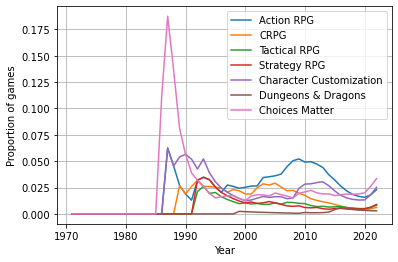

In [45]:
tagProportionPlot(['Action RPG','CRPG','Tactical RPG', 'Strategy RPG','Character Customization', 'Dungeons & Dragons','Choices Matter'])

In [46]:
#Plot change in proportion of RPGs over time
plt.figure()

dates = range(min(ncrpgs_df['releaseDate']).year,dt.now().year)

plt.plot([dates[i] for i in range(len(dates)) if allGamesCount[i]>0], [ncrpgCount[i]/allGamesCount[i] for i in range(len(dates)) if allGamesCount[i]>0],label='non-CRPGs')
plt.plot([dates[i] for i in range(len(dates)) if allGamesCount[i]>0], [crpgCount[i]/allGamesCount[i] for i in range(len(dates)) if allGamesCount[i]>0],label='CRPGs')
# plt.plot(dates, crpgCount)

plt.title('RPG proportions over time')
plt.xlabel('Year')
plt.ylabel('Fraction of all contemporary games')

plt.legend()

NameError: name 'allGamesCount' is not defined

<Figure size 432x288 with 0 Axes>

In [47]:
#Plot change in proportion of RPGs over time
plt.figure()

dates = range(1985,dt.now().year)

plt.plot([dates[i] for i in range(len(dates)) if allGamesCount[i]>0], [pornGamesCount[i]/allGamesCount[i] for i in range(len(dates)) if allGamesCount[i]>0],label='Porn')


plt.title('Porn game proportions over time')
plt.xlabel('Year')
plt.ylabel('Fraction of all contemporary games')

plt.legend()

NameError: name 'allGamesCount' is not defined

<Figure size 432x288 with 0 Axes>